# ImageNet 데이터셋 검증 
> VGG16

### import

In [1]:
import os
from datetime import datetime

#### GPU 사용여부# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)

2.9.0


#### GPU 사용여부

In [2]:
print("GPU is", "available" if len(tf.config.list_physical_devices('GPU')) > 0 else "NOT AVAILABLE")

GPU is available


# ImageNet load

In [3]:
# Get imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Set data_dir to a read-only storage of .tar files
# Set write_dir to a w/r storage
data_dir = "D:/IMAGENET/data_dir/"

write_dir = "D:/IMAGENET/write_dir/"

# Construct a tf.data.Dataset
download_config = tfds.download.DownloadConfig(
                      extract_dir=os.path.join(write_dir, 'extracted'),
                      manual_dir=data_dir
                  )
download_and_prepare_kwargs = {
    'download_dir': os.path.join(write_dir, 'downloaded'),
    'download_config': download_config,
}
ds = tfds.load('imagenet2012_subset', 
               data_dir=os.path.join(write_dir, 'data'),         
               split='validation', 
               shuffle_files=False, 
               download=True, 
               as_supervised=True,
               download_and_prepare_kwargs=download_and_prepare_kwargs)

# VGG16

### Preprocess for VGG16|

image shape: (1, 224, 224, 3) label: ['European fire salamander']


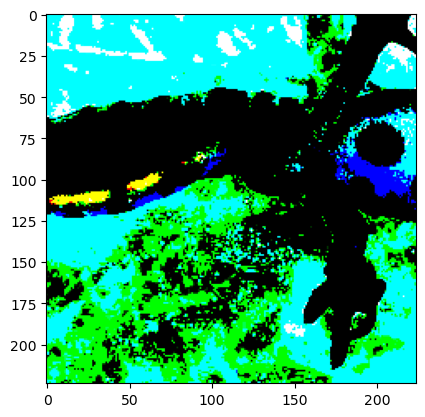

image shape: (1, 224, 224, 3) label: ['mushroom']


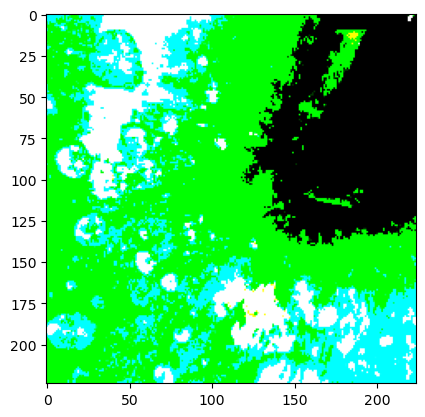

In [4]:
# Preprocess the images
def resize_with_crop_VGG16(image, label):
    i = image
    i = tf.cast(i, tf.float32)
    i = tf.image.resize_with_crop_or_pad(i, 224, 224)
    i = tf.keras.applications.vgg16.preprocess_input(i)
    return (i, label)

ds_VGG16 = ds.map(resize_with_crop_VGG16)

# Plot a few
ds_VGG16 = ds_VGG16.batch(1).prefetch(tf.data.experimental.AUTOTUNE)
for example in ds_VGG16.take(2):
    image, label = example
    print(f'image shape: {image.shape} label: {imagenet_labels[label]}')
    plt.imshow(tf.squeeze(image, axis=0))
    plt.show()

# Original weight

## Evaluation

In [5]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights='imagenet')
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>


C:\ProgramData\anaconda3\envs\torch\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


50000/50000 [==============================] - 466s 9ms/step - loss: 1.4129 - accuracy: 0.6703


In [7]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4128742218017578, 'accuracy': 0.6703000068664551}


# 30bit weight (zero to last 2-bit)

## Evaluation

In [8]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_30bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 475s 9ms/step - loss: nan - accuracy: 0.0010


In [10]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': nan, 'accuracy': 0.0010000000474974513}


# 28bit weight (zero to 4-bit)

## Evaluation

In [12]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_28bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 476s 10ms/step - loss: nan - accuracy: 0.0010


In [14]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': nan, 'accuracy': 0.0010000000474974513}


# 26bit weight (zero to 6-bit)

## Evaluation

In [15]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_26bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 485s 10ms/step - loss: 972617391886012513583653453824.0000 - accuracy: 0.0015


In [17]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 9.726173918860125e+29, 'accuracy': 0.0014799999771639705}


# 24bit weight (zero to 8-bit)

## Evaluation

In [18]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_24bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 469s 9ms/step - loss: 735952.0625 - accuracy: 0.2227


In [20]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 735952.0625, 'accuracy': 0.22271999716758728}


# 22bit weight (zero to 10-bit)

## Evaluation

In [21]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_22bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 465s 9ms/step - loss: 14.2949 - accuracy: 0.6407


In [23]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 14.294864654541016, 'accuracy': 0.6406999826431274}


# 20bit weight (zero to 12-bit)

## Evaluation

In [24]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_20bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 463s 9ms/step - loss: 1.8125 - accuracy: 0.6676


In [26]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.812535047531128, 'accuracy': 0.6675800085067749}


# 18bit weight (zero to 14-bit)

## Evaluation

In [27]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_18bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 462s 9ms/step - loss: 1.4529 - accuracy: 0.6699


In [29]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.452870488166809, 'accuracy': 0.669920027256012}


# 16bit weight (zero to 16-bit) - half

## Evaluation

In [30]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_16bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 455s 9ms/step - loss: 1.4199 - accuracy: 0.6701


In [32]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4198970794677734, 'accuracy': 0.6701400279998779}


# 14bit weight (zero to 18-bit)

## Evaluation

In [33]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_14bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 455s 9ms/step - loss: 1.4145 - accuracy: 0.6703


In [35]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.414457082748413, 'accuracy': 0.6703000068664551}


# 12bit weight (zero to 20-bit)

## Evaluation

In [36]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_12bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 456s 9ms/step - loss: 1.4132 - accuracy: 0.6702


In [38]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4132434129714966, 'accuracy': 0.6702200174331665}


# 10bit weight (zero to 22-bit)

## Evaluation

In [39]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_10bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 458s 9ms/step - loss: 1.4130 - accuracy: 0.6703


In [41]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4129643440246582, 'accuracy': 0.6703199744224548}


# 8bit weight (zero to 24-bit)

## Evaluation

In [42]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_8bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 456s 9ms/step - loss: 1.4129 - accuracy: 0.6703


In [44]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4128847122192383, 'accuracy': 0.6703199744224548}


# 6bit weight (zero to 26-bit)

## Evaluation

In [45]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_6bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 455s 9ms/step - loss: 1.4129 - accuracy: 0.6703


In [47]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4128782749176025, 'accuracy': 0.6703000068664551}


# 4bit weight (zero to 28-bit)

## Evaluation

In [48]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_4bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 457s 9ms/step - loss: 1.4129 - accuracy: 0.6703


In [50]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4128766059875488, 'accuracy': 0.6703000068664551}


# 2bit weight (zero to 30-bit)

## Evaluation

In [51]:
model_VGG16 = tf.keras.applications.vgg16.VGG16(include_top=True,
                                                     weights=r"C:\Users\김정헌\OneDrive\바탕 화면\slim\mask_vgg16\mask_vgg16_weights_tf_dim_ordering_tf_kernels_2bit.h5")
model_VGG16.trainable = False
model_VGG16.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
tf.keras.applications.vgg16.decode_predictions = tf.keras.applications.xception.decode_predictions

print("<Evaluate model>")
result_VGG16 = model_VGG16.evaluate(ds_VGG16)

<Evaluate model>
50000/50000 [==============================] - 458s 9ms/step - loss: 1.4129 - accuracy: 0.6703


In [53]:
print(dict(zip(model_VGG16.metrics_names, result_VGG16)))

{'loss': 1.4128754138946533, 'accuracy': 0.6703000068664551}


---
---
---

# Visualization
> top-1 accuracy

In [54]:
accuracy_decend = [0.6703000068664551, 0.6703000068664551, 0.6703000068664551, 0.6703000068664551, 0.6703199744224548, 0.6703199744224548, 0.6702200174331665, 0.6703000068664551, 0.6701400279998779, 0.669920027256012, 0.6675800085067749, 0.6406999826431274, 0.22271999716758728, 0.0014799999771639705, 0.0010000000474974513, 0.0010000000474974513]
accuracy_decend

[0.6703000068664551,
 0.6703000068664551,
 0.6703000068664551,
 0.6703000068664551,
 0.6703199744224548,
 0.6703199744224548,
 0.6702200174331665,
 0.6703000068664551,
 0.6701400279998779,
 0.669920027256012,
 0.6675800085067749,
 0.6406999826431274,
 0.22271999716758728,
 0.0014799999771639705,
 0.0010000000474974513,
 0.0010000000474974513]

In [55]:
bit_accend = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
bit_decend = bit_accend[::-1]

In [70]:
bit_decend

[32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2]

### 전체적인 시각화

| bit (assumption) | accuracy |
|------------------|----------|
| 32               | 0.6703400015830994 |
| 30               | 0.6703199744224548 |
| 28               | 0.6703199744224548 |
| 26               | 0.6703199744224548 |
| 24               | 0.6703400015830994 |
| 22               | 0.6703000068664551 |
| 20               | 0.6703199744224548 |
| 18               | 0.6703600287437439 |
| 16               | 0.6704199910163879 |
| 14               | 0.6700599789619446 |
| 12               | 0.6652600169181824 |
| 10               | 0.5178200006484985 |
| 8                | 0.0010000000474974513 |
| 6                | 0.0010000000474974513 |
| 4                | 0.0010000000474974513 |
| 2                | 0.0010000000474974513 |


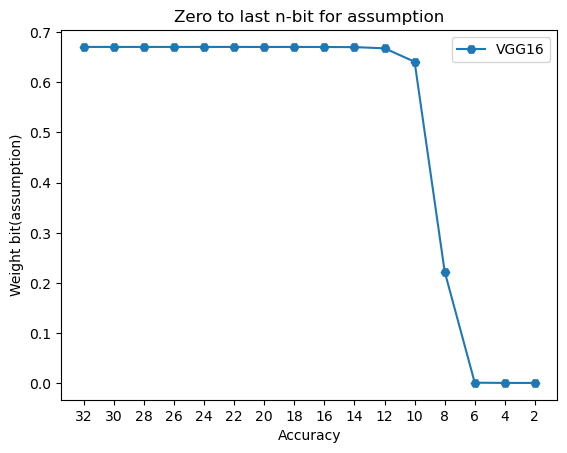

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.plot(bit_decend, accuracy_decend, marker='H')
plt.xlabel('Accuracy')
plt.ylabel('Weight bit(assumption)')
plt.title('Zero to last n-bit for assumption')
plt.legend(['VGG16'])

# Set the x-ticks to show all the values in the bit_decend list
plt.xticks(bit_decend)

# Invert the x-axis values
plt.gca().invert_xaxis()

plt.show()

## 32~12비트까지 시각화

In [57]:
bit_decend[:11]

[32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12]

In [58]:
len(accuracy_decend[:11])

11

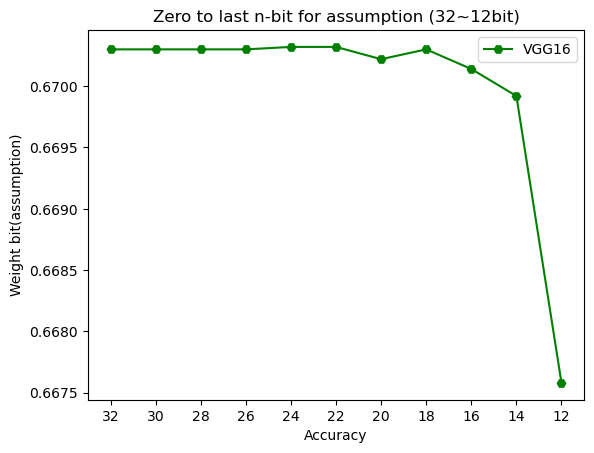

In [59]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.plot(bit_decend[:11], accuracy_decend[:11], marker='H', color='green')
plt.xlabel('Accuracy')
plt.ylabel('Weight bit(assumption)')
plt.title('Zero to last n-bit for assumption (32~12bit)')
plt.legend(['VGG16'])

# Set the x-ticks to show all the values in the bit_decend list
plt.xticks(bit_decend[:11])

# Invert the x-axis values
plt.gca().invert_xaxis()

plt.show()

## 12~2비트까지 시각화

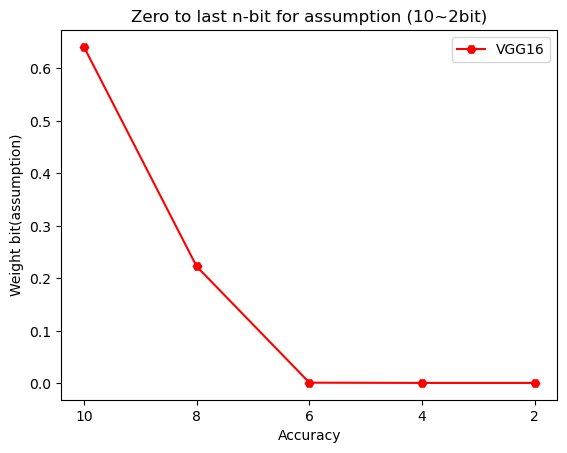

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.plot(bit_decend[11:], accuracy_decend[11:], marker='H', color='red')
plt.xlabel('Accuracy')
plt.ylabel('Weight bit(assumption)')
plt.title('Zero to last n-bit for assumption (10~2bit)')
plt.legend(['VGG16'])

# Set the x-ticks to show all the values in the bit_decend list
plt.xticks(bit_decend[11:])

# Invert the x-axis values
plt.gca().invert_xaxis()

plt.show()